In [1]:
import pandas as pd
from typing import List, Tuple
import numpy as np

from cerberus_builder_attention_noneck import build_cerberus, train_cerberus
from preprocess import create_min_max_df, scale_data, downsample_timeseries_data, slice_timeseries_data, masked_expand
from postprocess import generate_predictions

In [2]:
# Example usage:
df = pd.read_csv(r"../data/jena_climate_2009_2016.csv",
                parse_dates=['Date Time'], 
                index_col=['Date Time'])
df.index = pd.to_datetime(df.index, format='%d.%m.%Y %H:%M:%S')
df = df.iloc[:5000,:]
context_windows = ['1H', '2H', '6H']
context_sizes = [24, 12, 6]
call_window = '10T'
call_size = 24
response_window = '10T'
response_size = 8
call_feature_index = range(0,14)
context_feature_index = [range(0,14),
                        range(0,14),
                        range(0,14)]
response_feature_index = [0, 1, 4]
thresholds = {
    'call': 0.7,
    'response': 0.7,
    'context_0': 0.7,
    'context_1': 0.7,
    'context_2': 0.7
}
sizes = {
    'call': 24,
    'response': 8,
    'context_0': 24,
    'context_1': 12,
    'context_2': 6
}

In [3]:
#Scale Data
min_max_df = create_min_max_df(df)
print(min_max_df)
scaled_df = scale_data(df, min_max_df, feature_range=(0, 1))

                     min      max
p (mbar)          944.58  1005.71
T (degC)          -23.01     7.64
Tpot (K)          250.60   283.19
Tdew (degC)       -25.01     2.51
rh (%)             42.38   100.00
VPmax (mbar)        0.95    10.48
VPact (mbar)        0.79     7.32
VPdef (mbar)        0.00     4.94
sh (g/kg)           0.50     4.80
H2OC (mmol/mol)     0.80     7.69
rho (g/m**3)     1179.43  1383.38
wv (m/s)            0.00     9.71
max. wv (m/s)       0.00    14.50
wd (deg)            0.00   358.90


In [4]:
downsampled_data = downsample_timeseries_data(scaled_df, 
                                        context_windows, 
                                        call_window, 
                                        response_window,
                                        call_feature_index,
                                        context_feature_index,
                                        response_feature_index)
downsampled_data

{'call':                      p (mbar)  T (degC)  Tpot (K)  Tdew (degC)    rh (%)  \
 2009-01-01 00:10:00  0.849665  0.489070  0.454127     0.585392  0.883721   
 2009-01-01 00:20:00  0.850483  0.476346  0.442160     0.571584  0.885456   
 2009-01-01 00:30:00  0.849828  0.473083  0.439092     0.570494  0.894134   
 2009-01-01 00:40:00  0.849501  0.479608  0.445535     0.579215  0.899341   
 2009-01-01 00:50:00  0.849501  0.480914  0.446456     0.580305  0.897605   
 ...                       ...       ...       ...          ...       ...   
 2009-02-04 16:40:00  0.435302  0.821207  0.829396     0.897892  0.717112   
 2009-02-04 16:50:00  0.435302  0.813703  0.822031     0.898256  0.743145   
 2009-02-04 17:00:00  0.435793  0.813703  0.822031     0.901163  0.751822   
 2009-02-04 17:10:00  0.438737  0.811746  0.820190     0.900073  0.753558   
 2009-02-04 17:20:00  0.442827  0.815661  0.822952     0.904070  0.753558   
 
                      VPmax (mbar)  VPact (mbar)  VPdef (mbar)  sh

In [5]:
sliced_data, selected_timestamps = slice_timeseries_data(downsampled_data,
                                    sizes,
                                    thresholds)

sliced_data

{'context_0': array([[[0.87313921, 0.4473627 , 0.41162933, ..., 0.08427738,
          0.10356322, 0.40466704],
         [0.88508097, 0.47199565, 0.43315946, ..., 0.14469619,
          0.13390805, 0.91028142],
         [0.89639566, 0.49211528, 0.45044492, ..., 0.05217988,
          0.06045977, 0.61177673],
         ...,
         [0.88276351, 0.60609027, 0.5595786 , ..., 0.06591143,
          0.07195402, 0.51109873],
         [0.87602923, 0.59624796, 0.55139613, ..., 0.07621009,
          0.08632184, 0.48611498],
         [0.87551121, 0.59510604, 0.55037333, ..., 0.07020254,
          0.08494253, 0.57341414]],
 
        [[0.87313921, 0.4473627 , 0.41162933, ..., 0.08427738,
          0.10356322, 0.40466704],
         [0.88508097, 0.47199565, 0.43315946, ..., 0.14469619,
          0.13390805, 0.91028142],
         [0.89639566, 0.49211528, 0.45044492, ..., 0.05217988,
          0.06045977, 0.61177673],
         ...,
         [0.88276351, 0.60609027, 0.5595786 , ..., 0.06591143,
          0

In [6]:
for key in sliced_data:
    print(sliced_data[key].shape)

(4816, 24, 14)
(4816, 12, 14)
(4816, 6, 14)
(4816, 24, 14)
(4816, 8, 3)


In [7]:
expanded_dict, response_data = masked_expand(sliced_data, sizes)

print(response_data[0,:])
for ir in range(30):
    print(expanded_dict['response'][ir,:,:])
    
for key in expanded_dict:
    print(expanded_dict[key].shape)
    
print(response_data.shape)

[0.87387535 0.60619902 0.93405068]
[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[[0.87387535 0.60619902 0.93405068]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.87387535 0.60619902 0.93405068]
 [0.87567479 0.60783034 0.92884415]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[[0.87387535 0.60619902 0.93405068]
 [0.87567479 0.60783034 0.92884415]
 [0.87632913 0.60978793 0.92884415]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]
 [0.         0.         0.        ]]
[

In [8]:
model = build_cerberus(expanded_dict, response_data, 64)

24
14


Epoch 1/30
1084/1084 [==============================] - 55s 48ms/step - loss: 0.0034 - val_loss: 0.0012
Epoch 2/30
1084/1084 [==============================] - 54s 50ms/step - loss: 5.0677e-04 - val_loss: 9.6695e-04
Epoch 3/30
1084/1084 [==============================] - 55s 50ms/step - loss: 3.8568e-04 - val_loss: 0.0011
Epoch 4/30
1084/1084 [==============================] - 54s 50ms/step - loss: 3.5430e-04 - val_loss: 0.0011
Epoch 5/30
1084/1084 [==============================] - 56s 51ms/step - loss: 3.1604e-04 - val_loss: 0.0010
Epoch 6/30
1084/1084 [==============================] - 61s 56ms/step - loss: 3.0414e-04 - val_loss: 0.0011
Epoch 7/30
1084/1084 [==============================] - 56s 52ms/step - loss: 2.6596e-04 - val_loss: 0.0011
Epoch 8/30
1084/1084 [==============================] - 62s 57ms/step - loss: 2.7043e-04 - val_loss: 0.0010
Epoch 9/30
1084/1084 [==============================] - 55s 50ms/step - loss: 2.4329e-04 - val_loss: 0.0011
Epoch 10/30
1084/1084 [=====

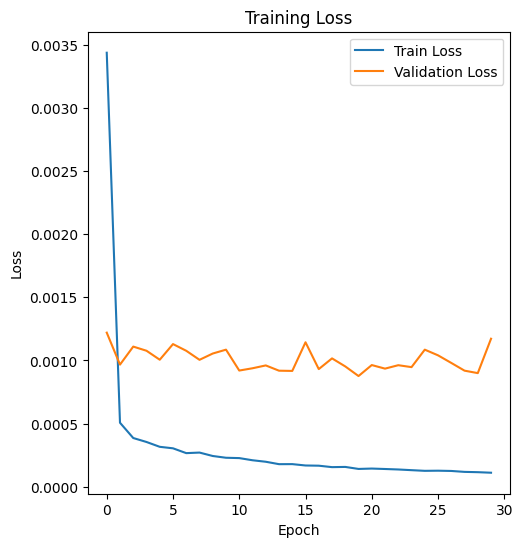

In [9]:
model = train_cerberus(model,expanded_dict, response_data, 30)

In [12]:
selected_data = {key: value[400:401,:] for key, value in sliced_data.items()}
responses_generated = generate_predictions(model,selected_data)
print(selected_data['response'])
print(responses_generated)

1/1 [==============================] - 0s 34ms/step
[[[0.80484214 0.53442088 0.78306144]
  [0.80729593 0.53213703 0.76744186]
  [0.80974971 0.53017945 0.77264839]
  [0.81122199 0.53083197 0.79000347]
  [0.81253067 0.52724307 0.78479695]
  [0.81285784 0.51973899 0.74835127]
  [0.81318502 0.50766721 0.67545991]
  [0.81531163 0.50212072 0.64595627]]]
[[0.81210536 0.53103846 0.79195595]
 [0.8177408  0.5353327  0.7896328 ]
 [0.81995875 0.52938783 0.78869593]
 [0.8191075  0.5256645  0.7848257 ]
 [0.81960905 0.5222462  0.7814925 ]
 [0.82245547 0.51666164 0.75548685]
 [0.8233543  0.5115763  0.73748267]
 [0.8243319  0.5064166  0.7196342 ]]


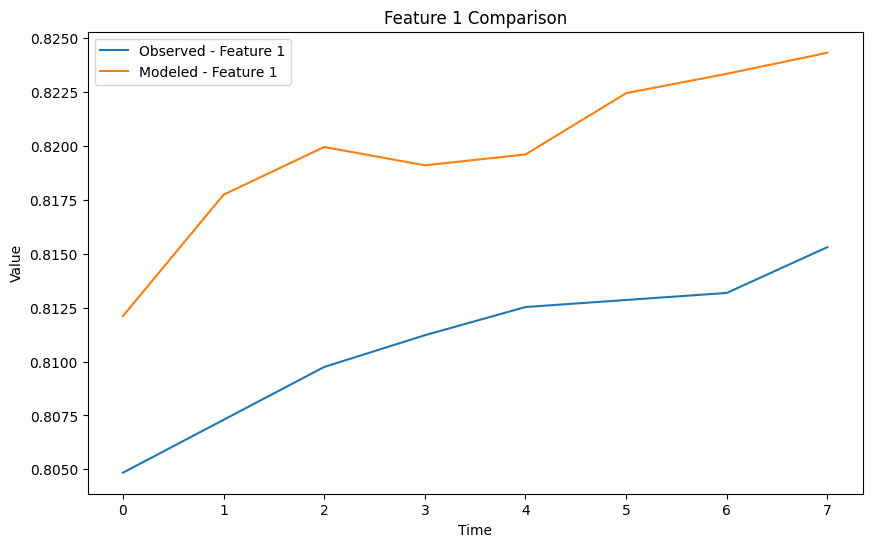

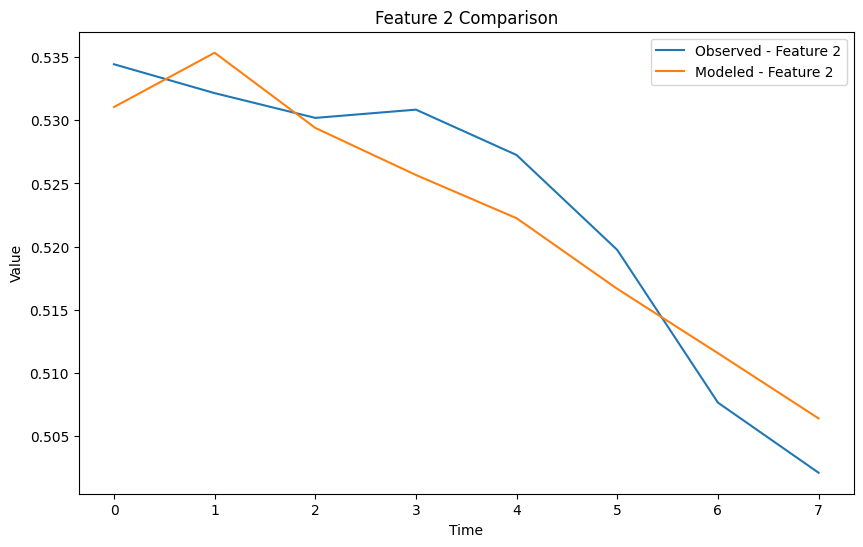

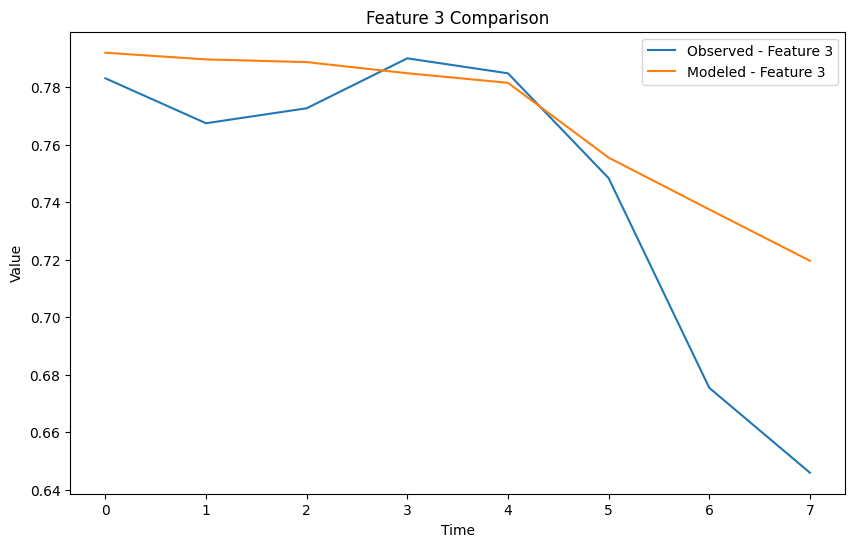

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Example matrices
observed = selected_data['response'][0,:,:]
modeled = responses_generated

# Number of rows and columns
num_rows, num_cols = observed.shape

# Create a plot for each feature (column)
for i in range(num_cols):
    plt.figure(figsize=(10, 6))
    plt.plot(observed[:, i], label='Observed - Feature {}'.format(i+1))
    plt.plot(modeled[:, i], label='Modeled - Feature {}'.format(i+1))
    plt.title(f'Feature {i+1} Comparison')
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.legend()
    plt.show()
